# Analyzing Startup Fundraising Deals from Crunchbase

Assuming we have only 10 MB of memory. Our dataset `crunchbase-investments.csv` consumes 10.3 Mb - in pandas it will require 4 to 6 times more, thus, we will be working with chunks of 5000 rows.

# Reading the data

Let's become familiar with:

* each column's missing value counts
* each column's memory footprint
* the total memory footprint of all the chunks combined
* which column(s) we can drop because they aren't useful for analysis

In [5]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

crunchbase_investments_iter = pd.read_csv(
    'crunchbase-investments.csv',
    chunksize=5000,
    encoding='ISO-8859-1'
    )

null_counts_raw = []
memory_footprint_raw = pd.Series(dtype='float64')
counter = 0
rows = 0

for chunk in crunchbase_investments_iter:
    null_counts_raw.append(chunk.isnull().sum())
    if counter == 0:
        memory_footprint_raw = chunk.memory_usage(deep=True)
    else:
        memory_footprint_raw += chunk.memory_usage(deep=True)
    counter += 1
    rows += chunk.shape[0]

null_counts_combined = pd.concat(null_counts_raw)
null_counts = null_counts_combined.groupby(null_counts_combined.index).sum().sort_values()

memory_footprint = memory_footprint_raw.drop('Index').sort_values()
memory_footprint_total = memory_footprint_raw.sum()

print(f'Null values: \n\n{null_counts}',
      '\n\n',
      f'Memory footprint, in bytes: \n\n{memory_footprint}',
      '\n\n',
      f'Total memory footprint, in bytes: {memory_footprint_total}',
      '\n\n',
      f'rows: {rows}')

Null values: 

company_country_code          1
company_name                  1
company_permalink             1
company_region                1
investor_region               2
investor_permalink            2
investor_name                 2
funded_quarter                3
funded_at                     3
funded_month                  3
funded_year                   3
funding_round_type            3
company_state_code          492
company_city                533
company_category_code       643
raised_amount_usd          3599
investor_country_code     12001
investor_city             12480
investor_state_code       16809
investor_category_code    50427
dtype: int64 

 Memory footprint, in bytes: 

raised_amount_usd          422960
funded_year                422960
investor_category_code     602880
investor_state_code       2188119
investor_country_code     2320340
investor_city             2561163
company_state_code        2687027
company_country_code      2749224
funded_month              2

Now `total memory footprint is almost 60 Mb`.

Now we extract the first 10 rows.

In [7]:
crunchbase_investments = pd.read_csv(
    'crunchbase-investments.csv',
    nrows=10,
    encoding='ISO-8859-1'
    )

crunchbase_investments

,company_permalink,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_category_code,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/company/advercar,AdverCar,advertising,USA,CA,SF Bay,San Francisco,/company/1-800-flowers-com,1-800-FLOWERS.COM,NaN,USA,NY,New York,New York,series-a,2012-10-30,2012-10,2012-Q4,2012,2000000
1,/company/launchgram,LaunchGram,news,USA,CA,SF Bay,Mountain View,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-23,2012-01,2012-Q1,2012,20000
2,/company/utap,uTaP,messaging,USA,NaN,United States - Other,NaN,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-01,2012-01,2012-Q1,2012,20000
3,/company/zoopshop,ZoopShop,software,USA,OH,Columbus,columbus,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,angel,2012-02-15,2012-02,2012-Q1,2012,20000
4,/company/efuneral,eFuneral,web,USA,OH,Cleveland,Cleveland,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2011-09-08,2011-09,2011-Q3,2011,20000
5,/company/tackk,Tackk,web,USA,OH,Cleveland,Cleveland,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-02-01,2012-02,2012-Q1,2012,20000
6,/company/acclaimd,Acclaimd,analytics,USA,OH,Columbus,Columbus,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,angel,2012-06-01,2012-06,2012-Q2,2012,20000
7,/company/acclaimd,Acclaimd,analytics,USA,OH,Columbus,Columbus,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,angel,2012-08-07,2012-08,2012-Q3,2012,70000
8,/company/toviefor,ToVieFor,ecommerce,USA,NY,New York,New York,/company/2010-nyu-stern-business-plan-competition,2010 NYU Stern Business Plan Competition,NaN,NaN,NaN,unknown,NaN,angel,2010-04-01,2010-04,2010-Q2,2010,75000
9,/company/ohk-labs,OHK Labs,sports,USA,FL,Palm Beach,Boca Raton,/company/22hundred-group,22Hundred Group,NaN,NaN,NaN,unknown,NaN,angel,2011-09-01,2011-09,2011-Q3,2011,100000


The columns that will not be useful for further analysis: `investor_category_code` (50427 out of 52870 rows are missing), `company_permalink` and `investor_permalink` (because they are links).

In [9]:
drop_cols = ['investor_category_code', 'company_permalink', 'investor_permalink']
chunk = chunk.columns.drop(drop_cols)
chunk_cols = chunk.to_list

chunk_cols

<bound method IndexOpsMixin.tolist of Index(['company_name', 'company_category_code', 'company_country_code',
       'company_state_code', 'company_region', 'company_city', 'investor_name',
       'investor_country_code', 'investor_state_code', 'investor_region',
       'investor_city', 'funding_round_type', 'funded_at', 'funded_month',
       'funded_quarter', 'funded_year', 'raised_amount_usd'],
      dtype='object')>

In [10]:
keep_cols = ['company_name', 'company_category_code', 'company_country_code',
       'company_state_code', 'company_region', 'company_city', 'investor_name',
       'investor_country_code', 'investor_state_code', 'investor_region',
       'investor_city', 'funding_round_type', 'funded_at', 'funded_month',
       'funded_quarter', 'funded_year', 'raised_amount_usd']

# Selecting Data Types



In [12]:
crunchbase_investments.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   company_permalink       10 non-null     object
 1   company_name            10 non-null     object
 2   company_category_code   10 non-null     object
 3   company_country_code    10 non-null     object
 4   company_state_code      9 non-null      object
 5   company_region          10 non-null     object
 6   company_city            9 non-null      object
 7   investor_permalink      10 non-null     object
 8   investor_name           10 non-null     object
 9   investor_category_code  7 non-null      object
 10  investor_country_code   8 non-null      object
 11  investor_state_code     8 non-null      object
 12  investor_region         10 non-null     object
 13  investor_city           8 non-null      object
 14  funding_round_type      10 non-null     object
 15  funded_at

Let's check the inconsistency in column types across chuncks.

In [14]:
crunchbase_investments_iter = pd.read_csv(
    'crunchbase-investments.csv',
    chunksize=5000,
    encoding='ISO-8859-1'
    )

column_types_raw = {}
for chunk in crunchbase_investments_iter:
    for col in chunk.columns:
        column_type = str(chunk.dtypes[col])
        if col not in column_types_raw:
            column_types_raw[col] = [column_type]
        else:
            if column_type not in column_types_raw[col]:
                column_types_raw[col].append(column_type)
            
column_types_raw

{'company_permalink': ['object'],
 'company_name': ['object'],
 'company_category_code': ['object'],
 'company_country_code': ['object'],
 'company_state_code': ['object'],
 'company_region': ['object'],
 'company_city': ['object'],
 'investor_permalink': ['object'],
 'investor_name': ['object'],
 'investor_category_code': ['object', 'float64'],
 'investor_country_code': ['object', 'float64'],
 'investor_state_code': ['object', 'float64'],
 'investor_region': ['object'],
 'investor_city': ['object', 'float64'],
 'funding_round_type': ['object'],
 'funded_at': ['object'],
 'funded_month': ['object'],
 'funded_quarter': ['object'],
 'funded_year': ['int64', 'float64'],
 'raised_amount_usd': ['float64']}

Now we select only one type for controversial cases. Creating a dictionary with the types selected for reading the CSV file.

In [16]:
column_types = {'company_permalink': 'object',
 'company_name': 'object',
 'company_category_code': 'object',
 'company_country_code': 'object',
 'company_state_code': 'object',
 'company_region': 'object',
 'company_city': 'object',
 'investor_permalink': 'object',
 'investor_name': 'object',
 'investor_category_code': 'object',
 'investor_country_code': 'object',
 'investor_state_code': 'object',
 'investor_region': 'object',
 'investor_city': 'object',
 'funding_round_type': 'object',
 'funded_at': 'object',
 'funded_month': 'object',
 'funded_quarter': 'object',
 'funded_year': 'float64',
 'raised_amount_usd': 'float64'}

Optimizing the memory: changing object columns to categorical (if their values are less than 50% unique).

In [18]:
crunchbase_investments_iter = pd.read_csv(
    'crunchbase-investments.csv',
    chunksize=5000,
    encoding='ISO-8859-1',
    usecols=keep_cols,
    dtype = column_types
)
for chunk in crunchbase_investments_iter:
    object_columns = chunk.select_dtypes(include=['object'])
    chunk_length = chunk.shape[0]
    for column in object_columns:
        unique_values = object_columns[column].value_counts().shape[0]
        if unique_values/chunk_length < 0.5:
            chunk[column] = chunk[column].astype('category')
            
chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 50000 to 52869
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   company_name           2870 non-null   object  
 1   company_category_code  2860 non-null   category
 2   company_country_code   2870 non-null   category
 3   company_state_code     2841 non-null   category
 4   company_region         2870 non-null   category
 5   company_city           2825 non-null   category
 6   investor_name          2870 non-null   category
 7   investor_country_code  0 non-null      category
 8   investor_state_code    0 non-null      category
 9   investor_region        2870 non-null   category
 10  investor_city          0 non-null      category
 11  funding_round_type     2870 non-null   category
 12  funded_at              2870 non-null   category
 13  funded_month           2870 non-null   category
 14  funded_quarter         2870 non-nul

Let's also convert `funded_year` to categorical and try to downcast `raised_amount_usd` to a more space efficient subtype.

In [20]:
crunchbase_investments_iter = pd.read_csv(
    'crunchbase-investments.csv',
    chunksize=5000,
    encoding='ISO-8859-1',
    usecols=keep_cols,
    dtype = column_types
)
for chunk in crunchbase_investments_iter:
    chunk['raised_amount_usd'] = pd.to_numeric(chunk['raised_amount_usd'], downcast='float')
    chunk_length = chunk.shape[0]
    funded_year_vc = chunk['funded_year'].value_counts().shape[0]
    if funded_year_vc/chunk_length < 0.5:
        chunk['funded_year'] = chunk['funded_year'].astype('category')

chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 50000 to 52869
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   company_name           2870 non-null   object  
 1   company_category_code  2860 non-null   object  
 2   company_country_code   2870 non-null   object  
 3   company_state_code     2841 non-null   object  
 4   company_region         2870 non-null   object  
 5   company_city           2825 non-null   object  
 6   investor_name          2870 non-null   object  
 7   investor_country_code  0 non-null      object  
 8   investor_state_code    0 non-null      object  
 9   investor_region        2870 non-null   object  
 10  investor_city          0 non-null      object  
 11  funding_round_type     2870 non-null   object  
 12  funded_at              2870 non-null   object  
 13  funded_month           2870 non-null   object  
 14  funded_quarter         2870 non-nul

# Loading into SQLite database

Let's put it all together and export each chunk to a table in the SQLite database.

In [22]:
conn = sqlite3.connect('crunchbase-investments.db')

crunchbase_investments_iter = pd.read_csv(
    'crunchbase-investments.csv',
    chunksize=5000,
    encoding='ISO-8859-1',
    usecols=keep_cols,
    dtype = column_types
)

counter = 0
memory_footprint_raw = pd.Series(dtype='float64')

for chunk in crunchbase_investments_iter:
    chunk_length = chunk.shape[0]
    
    chunk['raised_amount_usd'] = pd.to_numeric(chunk['raised_amount_usd'], downcast='float')
    
    funded_year_vc = chunk['funded_year'].value_counts().shape[0]
    if funded_year_vc/chunk_length < 0.5:
        chunk['funded_year'] = chunk['funded_year'].astype('category')
        
    object_columns = chunk.select_dtypes(include=['object'])
    for column in object_columns:
        unique_values = object_columns[column].value_counts().shape[0]
        if unique_values/chunk_length < 0.5:
            chunk[column] = chunk[column].astype('category')
            
    if counter == 0:
        memory_footprint_raw = chunk.memory_usage(deep=True)
        counter += 1
    else:
        memory_footprint_raw += chunk.memory_usage(deep=True)
    
    chunk.to_sql('crunchbase_investments', conn, if_exists='append', index=False)
            
chunk.info()

memory_footprint_total = memory_footprint_raw.sum()

memory_footprint_total

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 50000 to 52869
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   company_name           2870 non-null   object  
 1   company_category_code  2860 non-null   category
 2   company_country_code   2870 non-null   category
 3   company_state_code     2841 non-null   category
 4   company_region         2870 non-null   category
 5   company_city           2825 non-null   category
 6   investor_name          2870 non-null   category
 7   investor_country_code  0 non-null      category
 8   investor_state_code    0 non-null      category
 9   investor_region        2870 non-null   category
 10  investor_city          0 non-null      category
 11  funding_round_type     2870 non-null   category
 12  funded_at              2870 non-null   category
 13  funded_month           2870 non-null   category
 14  funded_quarter         2870 non-nul

8636079

Now we need to check that data types in SQLite work as expected.

In [24]:
pd.read_sql('PRAGMA table_info(crunchbase_investments);', conn)

,cid,name,type,notnull,dflt_value,pk
0,0,company_name,TEXT,0,None,0
1,1,company_category_code,TEXT,0,None,0
2,2,company_country_code,TEXT,0,None,0
3,3,company_state_code,TEXT,0,None,0
4,4,company_region,TEXT,0,None,0
5,5,company_city,TEXT,0,None,0
6,6,investor_name,TEXT,0,None,0
7,7,investor_country_code,TEXT,0,None,0
8,8,investor_state_code,TEXT,0,None,0
9,9,investor_region,TEXT,0,None,0


# Analysis

What proportion of the total amount of funds did the top 10% raise? What about the top 1%? Compare these values to the proportions the bottom 10% and bottom 1% raised.


10 % companies: 1157

1 % companies: 116



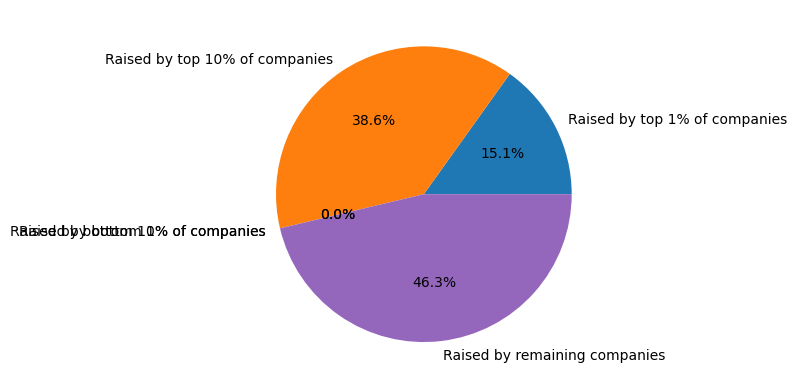

In [26]:
companies_sql = '''
    SELECT company_name
    FROM crunchbase_investments
    GROUP BY company_name
;'''

companies = pd.read_sql(companies_sql, conn)

companies_top10 = round((companies.shape[0])*0.1)
companies_top1 = round((companies.shape[0])*0.01)

print(f'''
10 % companies: {companies_top10}\n
1 % companies: {companies_top1}
''')



#doing two similar sql queries in order not to load hole database into dataframe

proportion_top_sql = '''
    SELECT COALESCE(SUM(raised_amount_usd), 0) as sum
    FROM crunchbase_investments
    GROUP BY company_name
    ORDER BY SUM(raised_amount_usd) DESC
    LIMIT 1157
;'''

proportion_top = pd.read_sql(proportion_top_sql, conn)['sum']
proportion_top10 = proportion_top.sum()
proportion_top1 = proportion_top[:116].sum()

proportion_bottom_sql = '''
    SELECT COALESCE(SUM(raised_amount_usd), 0) as sum
    FROM crunchbase_investments
    GROUP BY company_name
    ORDER BY SUM(raised_amount_usd)
    LIMIT 1157
;'''

proportion_bottom = pd.read_sql(proportion_bottom_sql, conn)['sum']
proportion_bottom10 = proportion_bottom.sum()
proportion_bottom1 = proportion_bottom[:116].sum()



proportion_rest_sql = f'''
    SELECT COALESCE(SUM(raised_amount_usd), 0) as sum
    FROM crunchbase_investments
    GROUP BY company_name
    LIMIT ({companies.shape[0]-1157*2})
    OFFSET 1157
;'''

proportion_rest = pd.read_sql(proportion_rest_sql, conn)['sum'].sum()

labels = ['Raised by top 1% of companies', 'Raised by top 10% of companies', 'Raised by bottom 1% of companies', 'Raised by bottom 10% of companies', 'Raised by remaining companies']
sizes = [proportion_top1, proportion_top10, proportion_bottom1, proportion_bottom10, proportion_rest]


proportion, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show(proportion)

Which category of company attracted the most investments (top 10)?

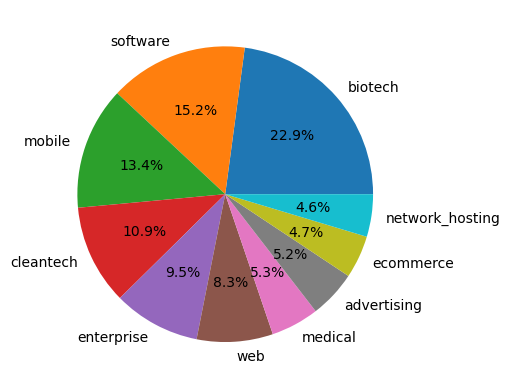

In [28]:
category_top10_sql = '''
    SELECT company_category_code, sum
    FROM (
        SELECT company_category_code, SUM(raised_amount_usd) as sum
        FROM crunchbase_investments
        GROUP BY company_category_code
        )
    ORDER BY sum DESC
    LIMIT 10
    ;'''

category_top10 = pd.read_sql(category_top10_sql, conn)

labels = category_top10['company_category_code']
sizes = category_top10['sum']


proportion, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show(proportion)

Which investor contributed the most money (across all startups)?

In [30]:
investor_top_sql = '''
    SELECT investor_name, SUM(raised_amount_usd) as sum
    FROM crunchbase_investments
    GROUP BY investor_name
    ORDER BY sum DESC
    LIMIT 1
    ;'''

investor_top = pd.read_sql(investor_top_sql, conn)
investor_top

,investor_name,sum
0,Kleiner Perkins Caufield & Byers,1.009604e+11


Which investors contributed the most money per startup?

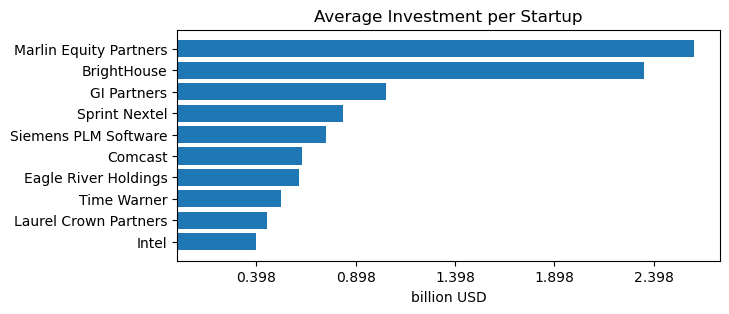

In [32]:
investor_avg_sql = '''
    SELECT investor_name, AVG(raised_amount_usd) as avg
    FROM crunchbase_investments
    GROUP BY investor_name
    ORDER BY AVG(raised_amount_usd) DESC
    ;'''

investor_avg = pd.read_sql(investor_avg_sql, conn)

investor_avg10_name = investor_avg.iloc[:10, 0]
investor_avg10_value = round((investor_avg.iloc[:10, 1])/1000000000, 3)

labels = investor_avg10_name
vals = investor_avg10_value

fig, ax = plt.subplots(figsize=(7,3))
y_pos = np.arange(len(labels))
ax.barh(y_pos, vals, align='center')
ax.set_yticks(y_pos, labels=labels)
ax.invert_yaxis()
ax.set_xlabel('billion USD')
ax.set_title('Average Investment per Startup')
plt.xticks(np.arange(min(vals), max(vals), 0.5))
plt.show()

Investors analysis: funded by top (1% and 10%) and bottom (1% and 10%).

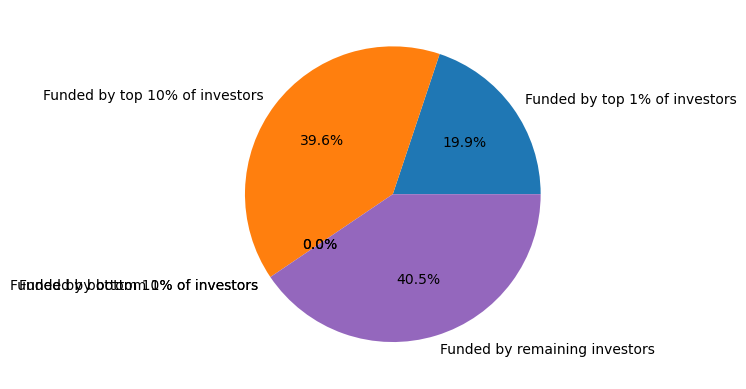

In [34]:
#doing two similar sql queries in order not to load hole database into dataframe

investors_top_sql = '''
    SELECT COALESCE(SUM(raised_amount_usd), 0) as sum
    FROM crunchbase_investments
    GROUP BY investor_name
    ORDER BY SUM(raised_amount_usd) DESC
    LIMIT 1157
;'''

investors_top = pd.read_sql(investors_top_sql, conn)['sum']
investors_top10 = investors_top.sum()
investors_top1 = investors_top[:116].sum()

investors_bottom_sql = '''
    SELECT COALESCE(SUM(raised_amount_usd), 0) as sum
    FROM crunchbase_investments
    GROUP BY investor_name
    ORDER BY SUM(raised_amount_usd)
    LIMIT 1157
;'''

investors_bottom = pd.read_sql(investors_bottom_sql, conn)['sum']
investors_bottom10 = investors_bottom.sum()
investors_bottom1 = investors_bottom[:116].sum()



investors_rest_sql = f'''
    SELECT COALESCE(SUM(raised_amount_usd), 0) as sum
    FROM crunchbase_investments
    GROUP BY investor_name
    LIMIT ({companies.shape[0]-1157*2})
    OFFSET 1157
;'''

investors_rest = pd.read_sql(investors_rest_sql, conn)['sum'].sum()


labels = ['Funded by top 1% of investors', 'Funded by top 10% of investors', 'Funded by bottom 1% of investors', 'Funded by bottom 10% of investors', 'Funded by remaining investors']
sizes = [investors_top1, investors_top10, investors_bottom1, investors_bottom10, investors_rest]


proportion, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show(proportion)

Which funding round was the most popular? Which was the least popular?

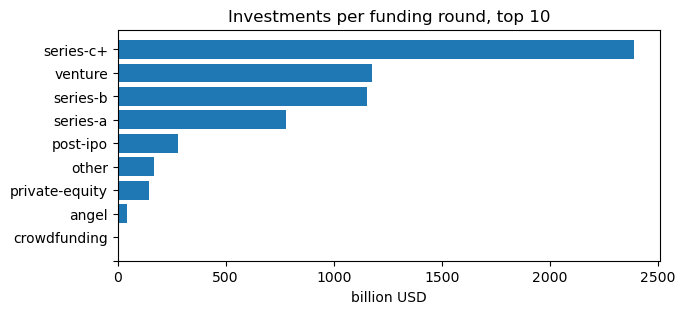

In [36]:
funding_round_sql = '''
    SELECT funding_round_type, SUM(raised_amount_usd) as total
    FROM crunchbase_investments
    GROUP BY funding_round_type
    ORDER BY SUM(raised_amount_usd) DESC
    LIMIT 10
    ;'''

funding_round = pd.read_sql(funding_round_sql, conn)


labels = funding_round['funding_round_type']
vals = round((funding_round['total'])/1000000000, 3)

fig, ax = plt.subplots(figsize=(7,3))
y_pos = np.arange(len(labels))
ax.barh(y_pos, vals, align='center')
ax.set_yticks(y_pos, labels=labels)
ax.invert_yaxis()
ax.set_xlabel('billion USD')
ax.set_title('Investments per funding round, top 10')
plt.show()

conn.close()

This was small analysis of Startup Fundraising Deals from Crunchbase using matplotlib.pyplot.